# DeepPolyLane
#### Lane detection expressed as a regression problem rather than a semantic classification.

Instead of representing lane lines as lit-up pixels in the output activations of a semantic segmentation CNN, the predictions of this CNN are polynomial coefficients (representing lane lines), their bounds and a set existence probablities. This was loosely inspired from YOLOv1, therefore you could argue that instead of dividing the image space into NxN grids and predicting bounding-box coordinates, this network divides the image space into vertical regions and outputs polynomial coefficients of the lane lines. My hypothesis is that it would remove a bulk of the convolution and de-convolution steps, which are expensive operations for embedded devices.

The motivation behind this CNN is to be able to run lane detection on one of my cheap edge AI boards, like Jetson Nano, preferably near real-time. 

Let's see!

In [1]:
def read_json_datasets(dataset_files):
    json_lines = []
    # read all the json strings from the file list
    for filename in dataset_files:
        json_dataset_file = open(filename, 'r')
        json_lines.append(json_dataset_file.readlines())
    # concat all the json lines into one list of newline-terminated strings
    json_lines = [ line for file_lines in json_lines for line in file_lines ]
    return json_lines
    

In [2]:
# Load the files linked to the training dataset and parse them

dataset_files = ['tusimple/train_set/label_data_0313.json', \
                 'tusimple/train_set/label_data_0531.json', \
                 'tusimple/train_set/label_data_0601.json']
train_json = read_json_datasets(dataset_files)
print('# of training examples: {}'.format(len(train_json)))

# of training examples: 3626


In [3]:
# Load the files linked to the test/validation dataset and parse them
dataset_files = ['tusimple/test_set/test_label.json']
val_json = read_json_datasets(dataset_files)
print('# of test examples: {}'.format(len(val_json)))

# of test examples: 2782


In [4]:
# randomize the new-line terminated strings.
import random
random.shuffle(train_json)
random.shuffle(val_json)

%matplotlib inline

# watch for any changes and re-load it automatically
%load_ext autoreload
%autoreload 2

#### Setup the training and validation data loaders

In [5]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

from load_data import TUSimpleLaneDataset
from load_data import Normalize, Rescale, ReorderLanes, ToTensor, NormalizeImageNet

from utilities import visualize_detections
import matplotlib.pyplot as plt

# define the transformation steps applied when loading each example
data_transforms = transforms.Compose([ \
                                      Rescale((224, 224)), \
                                      ReorderLanes(), \
                                      Normalize(), \
                                      ToTensor(), \
                                      NormalizeImageNet()])

In [6]:
# create a training dataset object, except the last n_valid data points

training_dataset = TUSimpleLaneDataset(train_json, 'tusimple/train_set/', data_transforms, cache_enabled=True)

# create a test dataset object out the last 100 images in the list.
validation_dataset = TUSimpleLaneDataset(val_json, 'tusimple/test_set/', data_transforms, \
                                        cache_enabled=True, cache_size=1200)

# iterate through the transformed dataset and print some stats about the first few samples
for i in range(4):
    sample = training_dataset[i]
    print(sample['image'].size(), sample['detections'].size())

torch.Size([3, 224, 224]) torch.Size([6, 2])
torch.Size([3, 224, 224]) torch.Size([6, 2])
torch.Size([3, 224, 224]) torch.Size([6, 2])
torch.Size([3, 224, 224]) torch.Size([6, 2])


In [7]:
# Create a training data loader
train_batch_len = 4
train_loader = DataLoader(training_dataset, batch_size=train_batch_len, shuffle=True, num_workers=0)

In [8]:
# Create a validation data loader
val_batch_len = 16
val_loader = DataLoader(validation_dataset, batch_size=val_batch_len, shuffle=True, num_workers=0)

In [9]:
samples = []
for i, sample in enumerate(val_loader):
    samples.append(sample)
    if i == 0:
        break
for sample in samples:
    img = sample['image']
    dtections = sample['detections']
    print('img shape: {}, dtectn shape: {}'.format(img.size(), dtections.size()))
    #visualize_detections(img, dtections)

img shape: torch.Size([16, 3, 224, 224]), dtectn shape: torch.Size([16, 6, 2])


In [10]:
from models import PolyNet, PolyNet2

In [11]:
import sys
import ssl

try:
    _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    pass
else:
    ssl._create_default_https_context = _create_unverified_https_context
    

import torch
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# device = "cpu"
net = PolyNet()
net = net.to(device)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /home/user/.cache/torch/checkpoints/resnet18-5c106cde.pth
100%|██████████| 44.7M/44.7M [01:31<00:00, 514kB/s] 


In [12]:
samples = []
for i, sample in enumerate(val_loader):
    samples.append(sample)
    if i == 0:
        break
for sample in samples:
    img = sample['image']
    dtections = sample['detections']
    print('img shape: {}, dtectn shape: {}'.format(img.size(), dtections.size()))
    pred_geo = net(img.type(torch.FloatTensor).to(device))
    pred_geo = pred_geo.view(-1, 6, 2).cpu()
    
    print('geo_shape: ', pred_geo.shape[0])
    #predicted_dtectn = torch.cat([existence, geo], dim=1)
    #print('pred shape: ', predicted_dtectn.shape)
    
    #visualize_detections(img, dtections)
    #visualize_detections(img, pred_geo)

img shape: torch.Size([16, 3, 224, 224]), dtectn shape: torch.Size([16, 6, 2])
geo_shape:  16


### Spank me harder! (define the loss function)
`MSELoss()` is like a strict parent and `SmoothL1Loss()` is the lenient and liberal one. However, even `MSELoss` did not seem to penalise errors in the terms like the cubic coefficient and the constant term sufficiently. Therefore, leading to imperfect alignment and under-estimated curvatures even on the training dataset. The cubic and the squared terms are particularly underestimated because their values are very small most of the time. That is why their effect needs to be magnified as well. 

Well.. not harder but spanking at the right and a safe place is the key ;)

In [14]:
from torch.nn import SmoothL1Loss, MSELoss

# coefficients for x = ay3 + by2 + cy + d and the ranges of y.
coefficient_weights = [1.0, 3.0, 2.0, 2.0, 1.5, 1.0]

loss_criteria = SmoothL1Loss()

num_lines = 2

def lane_line_loss(predicted, ground_truth):
    # reshape tensors into appropriate sizes
    
    #coeff_mask = torch.ones((ground_truth.shape[0], 6, 6), device=device)
    #for col_idx, coeff in enumerate(coefficient_weights):
    #    coeff_mask[:, :, col_idx] = coeff

    
    # reshape into appropriate sizes
    expected_geometry = ground_truth.view(-1, 6, num_lines) # Already in the correct shape before
    pred_geometry = predicted.view(-1, 6, num_lines)
    
    # scale the coeffcients across batches
    for row_idx, coeff in enumerate(coefficient_weights):
        expected_geometry[:, row_idx, :] *= coeff 
        pred_geometry[:, row_idx, :] *= coeff 
    
    
    # flatten the tensors for the loss_criteria
    expected = expected_geometry.view(expected_geometry.shape[0], -1)
    pred = pred_geometry.view(pred_geometry.shape[0], -1)
    
    # calculate the loss
    geometry_loss = loss_criteria(pred, expected)
    
    return geometry_loss
    

### Training 
Time to scorch them GPUs!

In [15]:
import torch.optim as optim

optimizer = optim.Adam(net.parameters(), lr=0.001)
# optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9)

In [16]:
# net.load_state_dict(torch.load('saved_models/polynet1.pt.bkp'))

In [17]:
from IPython.display import clear_output

model_dir = 'saved_models/'
model_name = 'polynet1.pt'

criteria = SmoothL1Loss()

def train_net(n_epochs):
    n_train = len(train_loader.dataset)
    n_test = len(val_loader.dataset)
    best_eval_loss = 10000000000.0
    
    # Store the losses for plotting.
    train_losses = []
    eval_losses = []
    
    for epoch in range(n_epochs):
        net.train()
        running_loss = 0.0
        train_loss = 0
        
        for batch_i, data in enumerate(train_loader):
            images = data['image']
            gt = data['detections']
            
            #gt = gt.view(gt.shape[0], -1) # Flatten the ground truth.
            
            images = images.type(torch.FloatTensor).to(device)
            gt = gt.type(torch.FloatTensor).to(device)
            
            pred_geo = net(images)
            
            #pred_geo = pred_geo.view(pred_geo.shape[0], -1) # Flatten the prediction
            
            loss = lane_line_loss(pred_geo, gt)
        
            #existence_loss, geometry_loss = lane_line_loss(predictions, gt)    
            #loss = existence_loss + geometry_loss
            
            
            optimizer.zero_grad() # zero the parameter (weight) gradients
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            train_loss += loss.item()
            if batch_i % 5 == 0:    # print every 10 batches
                print('Epoch: {}, {}/{}, Avg. Loss: {}, (conf, geo) : {}'.format(epoch + 1, (batch_i + 1) * train_batch_len,\
                                                               n_train, running_loss/(10 * train_batch_len),\
                                                               loss.item()), \
                                                               end='\r')
                running_loss = 0.0

        train_loss /= n_train
        train_losses.append(train_loss)
        print('\nEpoch {}, training loss: {}'.format(epoch + 1, train_loss))
        
        '''
        -------------------
        '''
        
        # evaluate the network performance at the end of every epoch.
        print('\nEvaluating...')
        net.eval()
        eval_loss = 0
        for batch_i, data in enumerate(val_loader):
            # get the input image and their labels
            
            images = data['image']
            gt = data['detections']
            #gt = gt.view(gt.shape[0], -1) # Flatten the ground truth.
            
            images = images.type(torch.FloatTensor).to(device)
            gt = gt.type(torch.FloatTensor).to(device)
            
            pred_geo = net(images)
            
            #pred_geo = pred_geo.view(pred_geo.shape[0], -1) # Flatten the prediction
            
            loss = lane_line_loss(pred_geo, gt)
            
            eval_loss += loss.item()
            
            if batch_i % 5 == 0:    # print every 10 batches
                print('Epoch: {}, {}/{}'.format(epoch + 1, (batch_i + 1) * val_batch_len,\
                                                               n_test), \
                                                               end='\r')
        eval_loss = eval_loss / n_test
        eval_losses.append(eval_loss)
        print('Epoch:{} Avg Eval Loss: {}'.format(epoch + 1, eval_loss))
        
        # save the best performing model
        if(eval_loss < best_eval_loss):
            # after training, save your model parameters in the dir 'saved_models'
            snapshot_name = model_dir+model_name
            print('Saving network: {}'.format(snapshot_name))
            torch.save(net.state_dict(), snapshot_name)
            best_eval_loss = eval_loss
            
        # Plot the training and validation losses.
        plt.clf()
        %matplotlib inline
        plt.grid(True)
        plt.xlim([0, n_epochs])
        plt.plot(train_losses, label = 'training loss')
        plt.plot(eval_losses, label = 'validation loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        #plt.show()
        plt.savefig('training_curves.png')
            

In [ ]:
#train_net(100)

In [20]:
net.load_state_dict(torch.load('saved_models/polynet1_v2.pt'))
#net.load_state_dict(torch.load('saved_models/polynet1_epoch53.pt'))
# net.load_state_dict(torch.load('saved_models/polynet1.pt'))

<All keys matched successfully>

In [ ]:
#train_net(60)

In [ ]:
# net.load_state_dict(torch.load('saved_models/polynet1_epoch53.pt'))
#torch.save(net.state_dict(), 'saved_models/polynet1_epoch53.pt')
#torch.save(net.state_dict(), 'saved_models/polynet1_v2.pt')

In [18]:
from utilities import visualize_detections
def sample_predictions():
    samples = []
    for i, sample in enumerate(val_loader):
        samples.append(sample)
        if i == 0:
            break
    
    img = samples[0]['image']
    dtections = samples[0]['detections']
    poly = net(img.type(torch.FloatTensor).to(device))
    poly = poly.view(-1, 6, 2).cpu()
    #bounds = bounds.view(-1, 2, 5).cpu()
    #print('detections: {}'.format(poly))
    visualize_detections(img[:4], poly[:4])
    print('------------------')
    #visualize_detections(img[:4], dtections[:4])

batch_size: 4


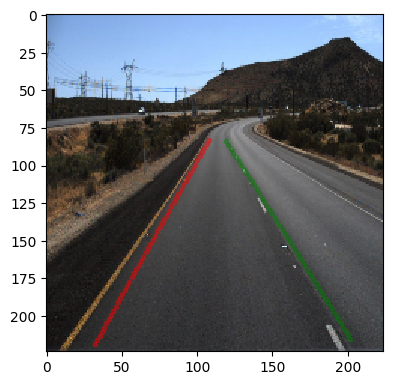

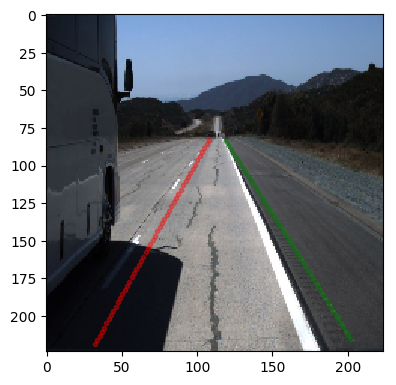

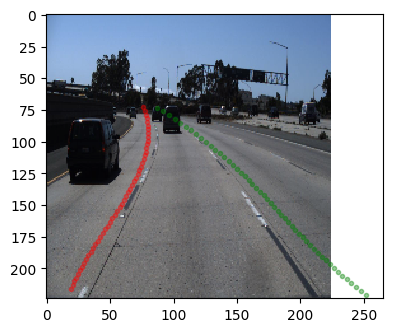

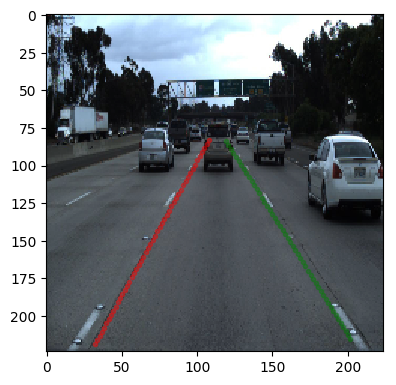

------------------


In [82]:
sample_predictions()